# Motivation
Modeling the sale price of a home could be valuable for multiple reasons: 
- To a real estate investor, understanding the future value of a property can guide purchasing strategies. 
- To a home buyer, a model could help inform them which house, in a set of potential purchases, is reasonably priced. 
- From the perspective of a governing entity, understanding the determinants of sales price can inform policy that seeks to create affordable housing or highlight and respond to volatility in housing markets.

# Overview
In this assignment, we will apply linear regression, polynomial regression, and
regularization techniques to predict the sale price of houses. The [dataset](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data) we use contains a rich set of features: 79 explanatory variables describing various  aspects of residential homes in Ames, Iowa.


# Goals

1) Predict the sales price of a home using a real-world dataset

2) Use regularization to avoid overfitting and improve model performance 

3) Explain how machine learning help us better understand variation in housing prices


In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Exploratory Data Analysis (EDA)

In [2]:
# Import data and check basic information
# Note: please use the dataset we provided on Canvas, do not use the one posted on Kaggle
df = pd.read_csv('./house_data.csv')
df.shape

(2919, 81)

In [3]:
# View variables
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


## Explore target variable

The variable: SalePrice - the property's sale price in dollars

The aim here is to better understand our target and verify its integrity. We will look at some summary statistics, empirical distribution and missing values.

In [5]:
print(df.SalePrice.describe()) # Look at summary statistics
print()
print("Number of missing values: {}".format(df.SalePrice.isna().sum())) 
print("Proportion of missing values: {:.4f}".format(df.SalePrice.isna().sum()/len(df)))

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Number of missing values: 1459
Proportion of missing values: 0.4998


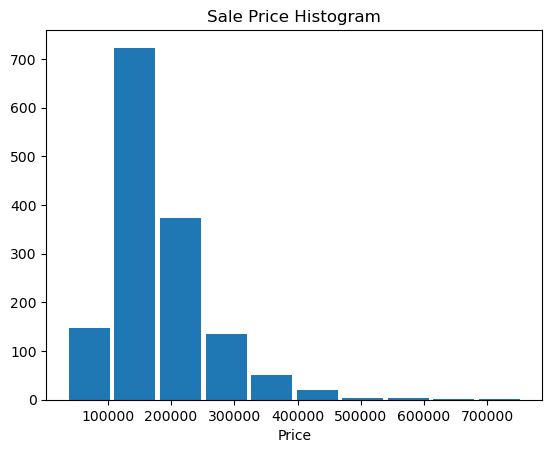

In [6]:
# Visualize the distribution
plt.hist(df.SalePrice, rwidth=0.9)
plt.xlabel('Price')
plt.title('Sale Price Histogram');

We gain some helpful informatino from all of this:
- First, we see that there are a significant amount of missing values -- we need to deal with these.
- Furthermore, we see that there are outliers on the upper end of the distribution, i.e., some houses are sold for extremely high prices.

Shape of data before dropping: (2919, 81)
Shape of data after dropping: (1460, 81)



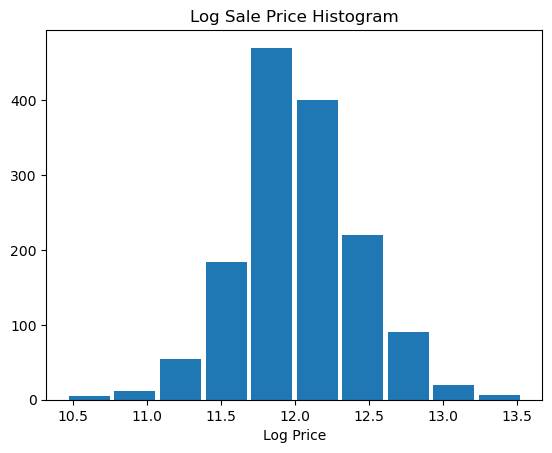

In [7]:
# Drop missing values
print('Shape of data before dropping: {}'.format(df.shape))
df_clean = df.drop(df[df['SalePrice'].isna()].index, axis=0)
print('Shape of data after dropping: {}'.format(df_clean.shape))
print()

# Data transformation: take log of the target variable, to reduce the range of the prices
df_clean['lg_SalePrice'] = np.log(df['SalePrice'])

# Visualize the transformed distribution
plt.hist(df_clean.lg_SalePrice, rwidth=0.9)
plt.xlabel('Log Price')
plt.title('Log Sale Price Histogram');

## Explore feature variables

We will now apply a similar approach to explore our features:

1) Check for and deal with missing values

2) Determine feature types

3) Clean features based on their type



## Missing values

In [9]:
# Change MAsVnrType into string value to prevent it from dropping
df_clean['MasVnrType'] = df_clean['MasVnrType'].astype(str)

In [10]:
# Check missing values
null_perct = df_clean.isna().sum()/len(df_clean)
null_perct[null_perct>0]

LotFrontage     0.177397
Alley           0.937671
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

In [11]:
# Note that some features have a large portion of missing observations (e.g., PoolQC).
# In response, we will drop columns that have more than 30% missing values.
# Recall that there are other potential ways to deal with missing values, such as imputation, but this is not the focus of this assignment.

print(df_clean.shape)
df_clean = df_clean.drop(columns=df_clean.columns[null_perct > 0.3])
print(df_clean.shape)

# feature size reduced from 82 to 77

(1460, 82)
(1460, 77)


In [13]:
# Next, we will drop samples with any remaining missing values.
print(df_clean.shape)
df_final = df_clean.dropna().reset_index(drop=True)
print(df_final.shape)

# sample size reduced from 1460 to 1094

(1460, 77)
(1094, 77)


## Explore feature types

What kind of feature types do we have? Organize features into types.

### Begin with numeric variables

In [14]:
# Identify numeric types
df_final.select_dtypes(['int', 'float']).dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
lg_SalePrice     float64
dtype: object

In [15]:
# Generate descriptive statistics for numeric variables
df_final.select_dtypes(['int', 'float']).describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,lg_SalePrice
count,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,...,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000
mean,727.375686,56.128885,70.759598,10132.346435,6.247715,5.575868,1972.412249,1985.915905,109.855576,448.191956,...,46.946984,22.053016,3.266910,16.498172,3.007313,23.550274,6.335466,2007.786106,187033.263254,12.057513
std,420.955488,41.976345,24.508859,8212.249621,1.366797,1.066500,31.189752,20.930772,190.667459,468.728095,...,64.820019,61.570502,29.655973,58.455303,40.713175,167.135237,2.694558,1.334307,83165.332151,0.394847
min,1.000000,20.000000,21.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000,10.471950
25%,366.500000,20.000000,60.000000,7606.750000,5.000000,5.000000,1953.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,132500.000000,11.794338
50%,723.500000,50.000000,70.000000,9444.500000,6.000000,5.000000,1975.000000,1995.000000,0.000000,384.500000,...,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,165750.000000,12.018235
75%,1093.750000,70.000000,80.000000,11387.250000,7.000000,6.000000,2003.000000,2005.000000,171.750000,712.750000,...,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,221000.000000,12.305918
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,547.000000,552.000000,508.000000,480.000000,648.000000,2500.000000,12.000000,2010.000000,755000.000000,13.534473


Note that we have both integer (e.g., YearBuilt, YrSold) and float (e.g., LotFrontage) variables.

While there are some integers such as MSSubClas, that one may want to treat differently, perhaps by one-hot encoding, here we will let them enter the regression as integer features.

In [16]:
# Collect numeric features to be included in later analysis
all_num_cols = df_final.select_dtypes(['int', 'float']).columns
num_cols = all_num_cols[1:len(all_num_cols)-2] # Collect numeric features, exclude ID and target variable
df_num = df_final[num_cols] # Exclude ID and target variable
print(df_num.shape)

(1094, 36)


### Check text/string variables 

In [17]:
# Pandas strings
df_final.select_dtypes(['object']).dtypes

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

In [18]:
# Tabulate variables to better understand their content
for col in df_final.select_dtypes(['object']).columns:
    print(df_final[col].value_counts(),'\n') 

MSZoning
RL         850
RM         173
FV          54
RH           9
C (all)      8
Name: count, dtype: int64 

Street
Pave    1090
Grvl       4
Name: count, dtype: int64 

LotShape
Reg    760
IR1    301
IR2     26
IR3      7
Name: count, dtype: int64 

LandContour
Lvl    991
Bnk     45
HLS     44
Low     14
Name: count, dtype: int64 

Utilities
AllPub    1094
Name: count, dtype: int64 

LotConfig
Inside     830
Corner     187
CulDSac     44
FR2         29
FR3          4
Name: count, dtype: int64 

LandSlope
Gtl    1045
Mod      44
Sev       5
Name: count, dtype: int64 

Neighborhood
NAmes      173
CollgCr    122
OldTown     96
Somerst     75
NridgHt     74
Edwards     65
Gilbert     49
NWAmes      45
Sawyer      44
SawyerW     44
BrkSide     42
Crawfor     41
NoRidge     33
Mitchel     30
Timber      29
IDOTRR      27
StoneBr     20
SWISU       19
BrDale      15
Blmngtn     14
ClearCr     11
MeadowV     10
Veenker      7
NPkVill      7
Blueste      2
Name: count, dtype: int64 

Condit

We see that these variables are categorical in nature. The next step will be to engineer these into many indicator variables using sklearn.preprocessing's OneHotEncoder.

In [19]:
# Collect text (i.e., object) variables
text_cols = df_final.select_dtypes(['object']).columns.to_list()

# Initiate OHE instance
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', dtype = np.int64) # Set drop to 'first' to aviod collinearity

# Fit OHE to the categorical features
ohe.fit(df_final[text_cols])

OneHotEncoder(drop='first', dtype=<class 'numpy.int64'>,
              handle_unknown='ignore')

In [20]:
# View categories
ohe.categories_

[array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object),
 array(['Grvl', 'Pave'], dtype=object),
 array(['IR1', 'IR2', 'IR3', 'Reg'], dtype=object),
 array(['Bnk', 'HLS', 'Low', 'Lvl'], dtype=object),
 array(['AllPub'], dtype=object),
 array(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'], dtype=object),
 array(['Gtl', 'Mod', 'Sev'], dtype=object),
 array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
        'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
        'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
        'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
        'Veenker'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe',
        'RRNn'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRNn'], dtype=object),
 array(['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'], dtype=object),
 array(['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story',
      

In [21]:
# Note: Many of the original features contain similar values.
# we will relabel these as FeatureName_value to make it self-explainable
new_col_names = []
index = 0
for arr, col_name in zip(ohe.categories_, text_cols):
    for ele in arr[1:]: # Skipping the first value label because our OHE model is set to drop the first feature value
        new_col_name = col_name + '_' + ele.strip(' ') 
        new_col_names.append(new_col_name)

# Create dataset of binary features
df_ohe = pd.DataFrame(ohe.transform(df_final[text_cols]).toarray(), columns=new_col_names)
print(df_ohe.shape)

(1094, 185)


In [26]:
new_col_names

['MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Pave',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'Condition1_Feedr',
 'Condition1_Norm',
 'Condition1_PosA',
 'Condition1_PosN',
 'Condition1_RRAe',
 '

# Finalize feature matrix and target variable, and create train-test split

In [22]:
# Create feature matrix by concatenating numeric and OHE dataframe
df_X = pd.concat([df_num, df_ohe], axis = 1)
feature_names = df_X.columns.to_list()
df_X.shape

(1094, 221)

In [23]:
# Create target variable
target = 'lg_SalePrice'
df_y = df_final[[target]]
df_y.shape

(1094, 1)

In [24]:
# Split data into train/test set
df_X_train, df_X_test, df_y_train, df_y_test  = train_test_split(df_X, df_y, test_size = 0.3, random_state = 42)

df_X_train.shape, df_X_test.shape
# created 765 training samples and 329 testing samples, each sample is represented with 221 features

((765, 221), (329, 221))

# Finally... regression time

In this subsection we will train and test the following models:

i) Linear Regression

ii) Polynomial Regression

iii) Lasso Regression (with L1 regularization)

iv) Ridge Regression (with L2 regularization)



## Linear Regression

Fit the linear regression model on the training set and evaluate model performance on the testing set (use the *score* function)
> Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [25]:
# Fit on the training data
reg = LinearRegression().fit(df_X_train, df_y_train)

# Evaluate
reg.score(df_X_test, df_y_test).round(3)

0.762

**Check the model coefficients and intercept**

- What are the largest positive and negative coefficients? 
- Commnet on some feature-coefficients in the context of the value of a house. Are they what you would expect?

Refer to the [data fields on Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data) to get more info of each feature. Remember, the OHE features are named according to the following schema: *FeatureName_value*

- The largest position coefficient is the RoofMatl_Membran, and the largest negative coefficient is the Condition2_PosN.
- According to the Kaggle dataset, the rooftop material with a large weight of coefficient makes sense here since the material of the rooftop determines the quality of the rooftop, and good quality of the house predicts higher value. The Condition2_PosN has a large weight of negative coefficient is also explainable here. Since this feature represent the proximity of main road or railroad, houses with this feature tend to bear with noises and bad traffic condition, especially Condition2 means a second is present. Thus, this feature predicts a lower value of the house.

In [27]:
df_linear_coef = pd.DataFrame({'features':reg.feature_names_in_, 'coefficients':np.round(reg.coef_[0],3)})

display(df_linear_coef.sort_values(['coefficients'], ascending=False).iloc[:10])
print()
display(df_linear_coef.sort_values(['coefficients'], ascending=True).iloc[:10])

,features,coefficients
106,RoofMatl_Membran,3.230
110,RoofMatl_WdShngl,2.756
108,RoofMatl_Tar&Grv,2.735
105,RoofMatl_CompShg,2.648
109,RoofMatl_WdShake,2.447
37,MSZoning_RH,0.465
36,MSZoning_FV,0.432
39,MSZoning_RM,0.390
38,MSZoning_RL,0.369
128,Exterior2nd_CmentBd,0.318


,features,coefficients
88,Condition2_PosN,-0.882
200,GarageQual_Po,-0.269
114,Exterior1st_CemntBd,-0.218
198,GarageQual_Fa,-0.212
62,Neighborhood_MeadowV,-0.198
186,Functional_Maj2,-0.194
52,LandSlope_Sev,-0.193
199,GarageQual_Gd,-0.192
201,GarageQual_TA,-0.177
176,HeatingQC_Po,-0.176


## Polynomial regression

Let's now add some new polynomial features constructed from our numerical features
- Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
- Note that we are using the same training and testing dataset from the above steps

**First**, we will pick some numerical features to do polynomial transformation on the **training data**

In [28]:
# We will apply the polynomial transform to our float variables
poly_cols = df_X_train.select_dtypes(['float']).columns

In [38]:
poly_cols

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [29]:
# We start with second degree polynomial features 
poly2 = PolynomialFeatures(degree=2, include_bias=True)

# Fit and transform selected features of traning data to polynomial representation
poly2_features_train = pd.DataFrame(poly2.fit_transform(df_X_train[poly_cols]),
                                    columns = poly2.get_feature_names_out(poly_cols))


In [32]:
poly2_features_train

,1,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,...,BsmtHalfBath^2,BsmtHalfBath GarageYrBlt,BsmtHalfBath GarageCars,BsmtHalfBath GarageArea,GarageYrBlt^2,GarageYrBlt GarageCars,GarageYrBlt GarageArea,GarageCars^2,GarageCars GarageArea,GarageArea^2
0,1.0,65.0,0.0,0.0,0.0,702.0,702.0,0.0,0.0,1994.0,...,0.0,0.0,0.0,0.0,3976036.0,3988.0,683942.0,4.0,686.0,117649.0
1,1.0,65.0,0.0,0.0,0.0,1584.0,1584.0,0.0,0.0,1967.0,...,0.0,0.0,0.0,0.0,3869089.0,5901.0,1557864.0,9.0,2376.0,627264.0
2,1.0,60.0,0.0,0.0,0.0,596.0,596.0,0.0,0.0,1920.0,...,0.0,0.0,0.0,0.0,3686400.0,1920.0,362880.0,1.0,189.0,35721.0
3,1.0,100.0,272.0,442.0,0.0,374.0,816.0,0.0,1.0,1964.0,...,1.0,1964.0,2.0,540.0,3857296.0,3928.0,1060560.0,4.0,1080.0,291600.0
4,1.0,50.0,0.0,0.0,0.0,636.0,636.0,0.0,0.0,1937.0,...,0.0,0.0,0.0,0.0,3751969.0,1937.0,464880.0,1.0,240.0,57600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,1.0,40.0,0.0,365.0,0.0,75.0,440.0,0.0,0.0,1990.0,...,0.0,0.0,0.0,0.0,3960100.0,1990.0,700480.0,1.0,352.0,123904.0
761,1.0,61.0,192.0,903.0,0.0,126.0,1029.0,1.0,0.0,1961.0,...,0.0,0.0,0.0,0.0,3845521.0,1961.0,511821.0,1.0,261.0,68121.0
762,1.0,141.0,112.0,639.0,0.0,441.0,1080.0,1.0,0.0,1960.0,...,0.0,0.0,0.0,0.0,3841600.0,3920.0,1034880.0,4.0,1056.0,278784.0
763,1.0,88.0,245.0,0.0,0.0,1094.0,1094.0,0.0,0.0,2005.0,...,0.0,0.0,0.0,0.0,4020025.0,6015.0,1287210.0,9.0,1926.0,412164.0


In [43]:
# Add the ploynomial features to the other remaining features in our training data
# Exclude ~ original selected columns that are contained in poly2_features_train
poly2_train = pd.concat([df_X_train.loc[:,  ~df_X_train.columns.isin(poly_cols)].reset_index(),
                         poly2_features_train], axis=1)

# Set index back to the original train data (when created, poly2_features_train has its indexed reset)
poly2_train = poly2_train.set_index(['index'])

poly2_train.shape

(765, 288)

In [44]:
poly2_train

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,BsmtHalfBath^2,BsmtHalfBath GarageYrBlt,BsmtHalfBath GarageCars,BsmtHalfBath GarageArea,GarageYrBlt^2,GarageYrBlt GarageCars,GarageYrBlt GarageArea,GarageCars^2,GarageCars GarageArea,GarageArea^2
index,,,,,,,,,,,,,,,,,,,,,
650,60,8125,6,5,1994,1995,702,779,0,1481,...,0.0,0.0,0.0,0.0,3976036.0,3988.0,683942.0,4.0,686.0,117649.0
1040,90,8944,5,5,1967,1967,1584,0,0,1584,...,0.0,0.0,0.0,0.0,3869089.0,5901.0,1557864.0,9.0,2376.0,627264.0
249,70,6402,5,5,1920,1950,596,596,0,1192,...,0.0,0.0,0.0,0.0,3686400.0,1920.0,362880.0,1.0,189.0,35721.0
786,60,9500,6,6,1964,1978,1127,850,0,1977,...,1.0,1964.0,2.0,540.0,3857296.0,3928.0,1060560.0,4.0,1080.0,291600.0
478,70,9000,5,6,1880,1991,1089,661,0,1750,...,0.0,0.0,0.0,0.0,3751969.0,1937.0,464880.0,1.0,240.0,57600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,30,4280,5,6,1913,2002,694,0,0,694,...,0.0,0.0,0.0,0.0,3960100.0,1990.0,700480.0,1.0,352.0,123904.0
466,20,7943,4,5,1961,1961,1029,0,0,1029,...,0.0,0.0,0.0,0.0,3845521.0,1961.0,511821.0,1.0,261.0,68121.0
121,20,31770,6,5,1960,1960,1656,0,0,1656,...,0.0,0.0,0.0,0.0,3841600.0,3920.0,1034880.0,4.0,1056.0,278784.0


**Think about why** do we do reset_index() and set_index(['indes']) in the above code?

- Since the polynomial process expanded the original features from 11 to 78, adding the features' squares and the interactions among them, which created a dataset 'poly2_features_train' with the index from 0 to 764. 
- However, the df_X_train dataset has a different index, with [650, 1040, 249, ...,1044,860]. 
- To make sure the newly added features can be added to the original training dataset df_X_train properly, without key error or inconsistency, we need to reset the rows' index in df_X_train, making a temporaral index column start from 0 to make sure all these features (df_X_train + ploy2_features_train) are maintaining the same orders starting from 0. 
- Finally, we change the index back to its original order. 

**Second**, we will apply the polynomial transformation to those selected features on the **testing data**
- **think about why** we do "fit_transform" on training data but only do "transform" on testing data?


- The function 'fit' is used to learn the pattern of the data. In poly2_features_train ,"fitting" means determining the coefficients that map the original features to polynomial features. The function 'transfrom' is using the parameters leanred in the 'fit' process to actually transform the data. For polynomial features, this means creating new polynomial features based on the original features and the learned coefficients. We only do transfrom on testing data because we don't want the model to learn the pattern on testing data because these data should be used for test model performance. If we fit the learned mechanism on testing data, the model performance will be influenced. 

In [45]:
# Transform on test data

poly2_features_test = pd.DataFrame(poly2.transform(df_X_test[poly_cols]),
                                   columns = poly2.get_feature_names_out(poly_cols))

# Add the ploynomial features to the other remaining features in our testing data
# Exclude ~ original selected columns that are contained in poly2_features_train
poly2_test = pd.concat([df_X_test.loc[:,  ~df_X_test.columns.isin(poly_cols)].reset_index(),
                        poly2_features_test],axis=1)

# Set index back to the original train data (when created, poly2_features_train has its indexed reset)
poly2_test = poly2_test.set_index(['index'])

poly2_test.shape

(329, 288)

**Third**, we will fit and evaluate the regression model with the newly generated polynomial feature matrix

In [47]:
# fit a regression model with the newly generated polynomial training feature matrix
poly2_reg = LinearRegression().fit(poly2_train, df_y_train)

# evaluate model performance on the polynomial testing feature matrix
poly2_reg.score(poly2_test, df_y_test).round(3)

0.889

Note the **test score improvment**! Presumably, our more complex model has learned to explain more variation in sales price that is generalizable to test data.

Let's see what happens if we do polynomial degree=3. 

## Your task:  implement polynomial degree=3
- please follow the above logics of degree=2 to write your own code for degree=3

**First**, do polynomial transformation on the poly_cols of the **training data**

In [49]:
poly3 = PolynomialFeatures(degree=3, include_bias=True)

# Fit and transform selected features of traning data to polynomial representation
poly3_features_train = pd.DataFrame(poly3.fit_transform(df_X_train[poly_cols]),
                                    columns = poly3.get_feature_names_out(poly_cols))

# Add the ploynomial features to the other remaining features in our training data
# Exclude ~ original selected columns that are contained in poly2_features_train
poly3_train = pd.concat([df_X_train.loc[:,  ~df_X_train.columns.isin(poly_cols)].reset_index(),
                         poly3_features_train], axis=1)

# Set index back to the original train data (when created, poly2_features_train has its indexed reset)
poly3_train = poly3_train.set_index(['index'])

poly3_train.shape

(765, 574)

**Second**, apply the polynomial transformation to the poly_cols of the **testing data**

In [50]:
poly3_features_test = pd.DataFrame(poly3.transform(df_X_test[poly_cols]),
                                   columns = poly3.get_feature_names_out(poly_cols))

# Add the ploynomial features to the other remaining features in our testing data
# Exclude ~ original selected columns that are contained in poly2_features_train
poly3_test = pd.concat([df_X_test.loc[:,  ~df_X_test.columns.isin(poly_cols)].reset_index(),
                        poly3_features_test],axis=1)

# Set index back to the original train data (when created, poly2_features_train has its indexed reset)
poly3_test = poly3_test.set_index(['index'])

poly3_test.shape

(329, 574)

**Third**, fit and evaluate the regression model with the newly generated polynomial feature matrix

In [51]:
# fit a regression model with the newly generated polynomial training feature matrix
poly3_reg = LinearRegression().fit(poly3_train, df_y_train)

# evaluate model performance on the polynomial testing feature matrix
poly3_reg.score(poly3_test, df_y_test).round(3)

-142.449

**Discussion**: based on what we learned in class about polynomial features, why the evaluation score is negative? what could be happening here? 

- As degree increased, we introduced the square of the features and their interactions to the original traning data. As the shape of X_trainging after transformation for degree=3 shows, the number of features has now 574. Compared to the original 11 features, a large increase in the amount of features might introduce useless noise and complexed the model. This increased in complexity will largely increase the risk of overfitting, which reduced the capacity of the model to make correct prediction, and thus cause the evaluation score to be negative. 

## Your task: Lasso Regression

Let's now fit and evaluate a Lasso regression model using the feature matrix that you just generated from polynomial **degree=3** 
- you can try parameter settings with alpha=.0006, tol=10e-2

In [149]:
# Fit model
poly3_lasso = Lasso(alpha=.0006, tol=10e-2).fit(poly3_train, df_y_train)

# Evaluate model performance 
poly3_lasso.score(poly3_test, df_y_test).round(3)

0.891

## Your task: Ridge regression
Let's now fit and evaluate a Ridge regression model using the polynomial features of **degree=3**

In [133]:
# Fit model
poly3_ridge = Ridge(alpha=.0006).fit(poly3_train, df_y_train)

# Evaluate model performance 
poly3_ridge.score(poly3_test, df_y_test).round(3)

-125.708

## Your task: compare the polynomial/ridge/lasso regression models
- write code to compare the three models we fit 
    - specifically, print the top-10 features with highest coefficients in each model 
    - expected running results are shown below

In [120]:
poly3_reg_df = pd.DataFrame({'features':poly3_reg.feature_names_in_, 'coefficients':np.round(poly3_reg.coef_[0],3)})
print("Top-10 highly correlated features in linear regression:")
display(poly3_reg_df.sort_values(['coefficients'], ascending=False).iloc[:10])

Top-10 highly correlated features in linear regression:


,features,coefficients
217,BsmtFullBath,22.249
273,BsmtFullBath^2,22.197
539,BsmtFullBath^3,22.094
285,GarageCars^2,5.581
219,GarageYrBlt,4.443
211,LotFrontage,4.022
469,BsmtFinSF2 TotalBsmtSF^2,2.956
497,BsmtUnfSF TotalBsmtSF^2,2.179
206,SaleCondition_Alloca,1.841
433,BsmtFinSF1 TotalBsmtSF^2,1.713


In [150]:
poly3_lasso_df = pd.DataFrame({'features':poly3_lasso.feature_names_in_, 'coefficients':np.round(poly3_lasso.coef_[0],3)})
print("Top-10 highly correlated features in lasso regression:")
display(poly3_lasso_df.sort_values(['coefficients'], ascending=False).iloc[:10])
print(poly3_lasso_df)

Top-10 highly correlated features in lasso regression:


,features,coefficients
0,MSSubClass,-0.0
385,MasVnrArea BsmtUnfSF GarageYrBlt,-0.0
379,MasVnrArea BsmtFinSF2 GarageCars,-0.0
380,MasVnrArea BsmtFinSF2 GarageArea,-0.0
381,MasVnrArea BsmtUnfSF^2,-0.0
382,MasVnrArea BsmtUnfSF TotalBsmtSF,-0.0
383,MasVnrArea BsmtUnfSF BsmtFullBath,-0.0
384,MasVnrArea BsmtUnfSF BsmtHalfBath,-0.0
386,MasVnrArea BsmtUnfSF GarageCars,-0.0
377,MasVnrArea BsmtFinSF2 BsmtHalfBath,-0.0


                     features  coefficients
0                  MSSubClass          -0.0
1                     LotArea          -0.0
2                 OverallQual          -0.0
3                 OverallCond          -0.0
4                   YearBuilt          -0.0
..                        ...           ...
569  GarageYrBlt GarageArea^2          -0.0
570              GarageCars^3          -0.0
571   GarageCars^2 GarageArea          -0.0
572   GarageCars GarageArea^2          -0.0
573              GarageArea^3          -0.0

[574 rows x 2 columns]


In [134]:
poly3_ridge_df = pd.DataFrame({'features':poly3_ridge.feature_names_in_, 'coefficients':np.round(poly3_ridge.coef_[0],3)})
print("Top-10 highly correlated features in ridge regression:")
display(poly3_ridge_df.sort_values(['coefficients'], ascending=False).iloc[:10])

Top-10 highly correlated features in ridge regression:


,features,coefficients
211,LotFrontage,1.573
26,MSZoning_RH,0.654
214,BsmtFinSF2,0.635
542,BsmtFullBath^2 GarageCars,0.559
25,MSZoning_FV,0.429
27,MSZoning_RL,0.392
285,GarageCars^2,0.385
28,MSZoning_RM,0.377
193,GarageCond_Po,0.376
216,TotalBsmtSF,0.367


In [40]:
# The original df

Top-10 highly correlated features in linear regression:


BsmtFullBath                         22.260
BsmtFullBath^2                       22.209
BsmtFullBath^3                       22.105
GarageCars^2                          5.581
GarageYrBlt                           4.444
LotFrontage                           4.023
BsmtFinSF1^2 TotalBsmtSF              2.866
SaleCondition_Alloca                  1.843
BsmtUnfSF TotalBsmtSF^2               1.440
BsmtFinSF1 BsmtFinSF2 TotalBsmtSF     1.245
Name: poly3_coef, dtype: float64


Top-10 highly correlated features in Lasso regression:


Neighborhood_StoneBr    0.124
Neighborhood_Crawfor    0.117
Neighborhood_NridgHt    0.096
Neighborhood_BrkSide    0.082
Functional_Typ          0.072
MSZoning_FV             0.065
SaleType_New            0.065
CentralAir_Y            0.053
OverallQual             0.053
Condition1_Norm         0.053
Name: l1_coef, dtype: float64


Top-10 highly correlated features in Ridge regression:


LotFrontage                  1.573
MSZoning_RH                  0.654
BsmtFinSF2                   0.635
BsmtFullBath^2 GarageCars    0.559
MSZoning_FV                  0.429
MSZoning_RL                  0.392
GarageCars^2                 0.385
MSZoning_RM                  0.377
GarageCond_Po                0.376
TotalBsmtSF                  0.367
Name: l2_coef, dtype: float64

## Your task: results interpretation and discussion

Write down your observations and thoughts after comparing the three models:
- hint:
    - what is the difference between ridge (L2 penalty) and Lasso (L1 penalty)?
    - explain how the two types of regularization affect coefficients and model performance

- L1 penalty adds the absolute value of the magnitude of coefficients to the loss function to penalize, while L2 penality adds the square. 
- L1 penalty can make certain coefficients equals to 0, but L2 regularization only shrinks the coefficients towards zero instead of the exactl zero.
- Since L1 penalty can leads to some coefficients deactive in prediction, it might cause sparsity and increase the risk of underfitting. L2 peanlty can be used when we want to emphasize only a few features with very large weights. Since L2 peanlity take the squares, it is more effective in penalizing features with large weights than L1 penalty. 
- L1 and L2 regularization tends to improve the model performance. In this task, both of them increased the model performance, but lasso largely improve the score compared to ridge. I guess this is because when we polynomial the model making the degree to 3, we create too many features that might cause noise in the prediction. Lasso, compared to Ridge, reduces those useless features to zero during the model training and thus improve the performance. Also, the coefficients for those features not reduced to zero, also shurken to a minimal value, and thus reduced the risk of overfitting.

When looking at the Lasso coefficients, which coefficients make the biggest change of decreading to 0. Does this make sense in the context of the housing prices? Please write down your code to produce the given data frame.

In [161]:
poly3_reg_df = pd.DataFrame({'features':poly3_reg.feature_names_in_, 'coefficients':np.round(poly3_reg.coef_[0],3)})
display(poly3_reg_df.sort_values(['coefficients'], ascending=False).iloc[:10])


,features,coefficients
217,BsmtFullBath,22.249
273,BsmtFullBath^2,22.197
539,BsmtFullBath^3,22.094
285,GarageCars^2,5.581
219,GarageYrBlt,4.443
211,LotFrontage,4.022
469,BsmtFinSF2 TotalBsmtSF^2,2.956
497,BsmtUnfSF TotalBsmtSF^2,2.179
206,SaleCondition_Alloca,1.841
433,BsmtFinSF1 TotalBsmtSF^2,1.713


In [167]:
poly3_reg_top10 =poly3_reg_df.sort_values(['coefficients'], ascending=False).iloc[:10]
poly3_features = list(poly3_reg_top10['features'])
poly3_features

['BsmtFullBath',
 'BsmtFullBath^2',
 'BsmtFullBath^3',
 'GarageCars^2',
 'GarageYrBlt',
 'LotFrontage',
 'BsmtFinSF2 TotalBsmtSF^2',
 'BsmtUnfSF TotalBsmtSF^2',
 'SaleCondition_Alloca',
 'BsmtFinSF1 TotalBsmtSF^2']

In [168]:
poly3_coef = list(poly3_reg_top10['coefficients'])
poly3_coef

[22.249, 22.197, 22.094, 5.581, 4.443, 4.022, 2.956, 2.179, 1.841, 1.713]

In [175]:
poly3_lasso_df = pd.DataFrame({'features':poly3_lasso.feature_names_in_, 'coefficients':np.round(poly3_lasso.coef_[0],3)})
lasso_coef = poly3_lasso_df.loc[poly3_lasso_df['features'].isin(poly3_features), ['features', 'coefficients']]
lasso_coef = lasso_coef['coefficients'].values
lasso_coef.tolist()

[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]

In [176]:
poly3_ridge_df = pd.DataFrame({'features':poly3_ridge.feature_names_in_, 'coefficients':np.round(poly3_ridge.coef_[0],3)})
ridge_coef = poly3_ridge_df.loc[poly3_ridge_df['features'].isin(poly3_features), ['features', 'coefficients']]
ridge_coef = ridge_coef['coefficients'].values
ridge_coef.tolist()

[-0.565, 1.573, 0.008, 0.354, 0.027, 0.385, -0.001, -0.004, -0.001, 0.065]

In [178]:
compare_top10 = pd.DataFrame({'poly3_coef': poly3_coef, 'L1_coef': lasso_coef, 'L2_coef': ridge_coef})
compare_top10.index = poly3_features
compare_top10

,poly3_coef,L1_coef,L2_coef
BsmtFullBath,22.249,-0.0,-0.565
BsmtFullBath^2,22.197,-0.0,1.573
BsmtFullBath^3,22.094,-0.0,0.008
GarageCars^2,5.581,-0.0,0.354
GarageYrBlt,4.443,-0.0,0.027
LotFrontage,4.022,-0.0,0.385
BsmtFinSF2 TotalBsmtSF^2,2.956,-0.0,-0.001
BsmtUnfSF TotalBsmtSF^2,2.179,-0.0,-0.004
SaleCondition_Alloca,1.841,-0.0,-0.001
BsmtFinSF1 TotalBsmtSF^2,1.713,-0.0,0.065


In [41]:
# The original df

,poly3_coef,l1_coef,l2_coef
BsmtFullBath,22.260,0.0,0.007
BsmtFullBath^2,22.209,-0.0,0.031
GarageYrBlt,4.444,0.0,0.354
LotFrontage,4.023,-0.0,1.573
BsmtFinSF1^2 TotalBsmtSF,2.866,0.0,-0.008
SaleCondition_Alloca,1.843,-0.0,-0.566
BsmtUnfSF TotalBsmtSF^2,1.440,-0.0,-0.007
BsmtFinSF1 BsmtFinSF2 TotalBsmtSF,1.245,-0.0,-0.002
BsmtFinSF1 BsmtUnfSF TotalBsmtSF,1.210,-0.0,0.005
BsmtFinSF2 TotalBsmtSF^2,0.994,-0.0,-0.005


When predicting the house price, lasso reduced the coefficients for most features to zero. For those features in the top 10 value, they also tend to have very small coefficients with similar values. This seems make no sense in actual housing price prediction, since in real prediction, different coefficients should have differnet correlation with the target variable. However, for lasso regression, many features all have the same coefficients, meaning that all of them have the same correlation with the target. At the same time, all features have no significant correlation with the target. The situation for lasso regression is different compread to ridge or linear regression. 

# Conclusion

Now at the end of this problem set, you've sucessfully applied regression classification to model the sale price of homes. 
- First, you began by cleaning and engineering the feature and target variables. 
- Next, you modeled the data using various techniques (polynomial transformation), including two commonly used regularization methods (L1 and L2). In the best model, you should have achieved an accuracy of nearly 90%!
- Lastly, this was all done in a social science setting. 
    - The results are meaningful in the sense that you're now better able to understand the determinants of housing prices in Ames, Iowa. 
    - Are these results generalizable to other housing markets in the US? That's beyond the scope of the data, but a question you could try to answer down the line using some of the skills developed from this work.


# [Optional challenge 1]
- In the above process, we select a set of features with "float" data type, and apply polynomial transformation for them. However, there could be a more intelligent way to select features for polynomial transformation. 
- Please propose your strategy of selecting features and re-implement the above process to see if model performance change. 
- E.g., you can select a set of features based on your sense of their potential correlations with the target variable. Please provide your reasoning.

# [Optional challenge 2]
- In the above code of generating polynomial feature matrix with degree=2 and degree=3, there are multiple repeated steps. From code efficiency perspective, we could write a function to better organize that. The following code provides a brief guide as a starting point, please fill in your implementation and feel free to make changes as needed, e.g.:
    - change input parameters
    - write extra helper functions 

In [ ]:
def gen_poly_features(poly_cols, degree):
    """
    Generate polynomial features for the given poly_cols and degree

    Inputs:
        poly_cols: the columns/features selected for polynomial transformation
        degree: the degree of polynomial transformation
    
    Returns: the generated polynomial feature matrix of the training and testing data
    """
    
    

- After completing the above function, please apply it to re-implement the polynomial feature transformantion and model fitting, and confirm whether your new results are consistent with the existing results.

# [Optional challenge 3]
- In this task, we practiced several regression models to predict the sale price of houses. Similarly, we can convert this task to a binary classification task (e.g., binarize the house price) and fit a LogisticRegression classifier. Please practice it for your own interest.